In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

In [ ]:
# !tar -xvf  '/content/drive/MyDrive/name_classifier/name_data.tar.gz' -C '/content/drive/MyDrive/name_classifier/'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from albumentations.pytorch import ToTensor

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import gzip
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(in_folder: str):
    """
    The in_folder will contain two files:
     - person.ttl
     - name.ttl

    You will need to combine the data to generate the y values (0 or 1),
    and train the model (see readme).
    """
    path = in_folder
    df = pd.read_csv(path)
    df = df.dropna()
    print("Shape of the data: ", df.shape)

    return df

In [ ]:
def split_data(data):
    """
    Generate data splits
    """
    path = data
    df = load_data(path)
    train = df[0:100000]
    validate = df[100000:150000]
    test = df[500000:550000]

    print(type(train))
    return train, validate, test

In [ ]:
x, y, z = split_data("/content/drive/MyDrive/name_classifier/data/dataset.csv")

Shape of the data:  (3003229, 3)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
x

,Unnamed: 0,name,class
0,0,Gold Cobra,0
1,1,Nielles-lès-Bléquin,0
2,2,Spaulding Turnpike(Portsmouth–Milton),0
3,3,White Mountain Highway (Milton–Gorham),0
4,4,Karel Matěj Čapek-Chod,1
...,...,...,...
100000,100000,Krzyków,0
100001,100001,Krzymowo,0
100002,100002,David Julian Hirsh,0
100003,100003,David Julius,1


In [ ]:
y

,Unnamed: 0,name,class
100005,100005,Coulours,0
100006,100006,7 Wonders of the Ancient World,0
100007,100007,David Kahn,0
100008,100008,David Kalivoda,1
100009,100009,Krzysztof Hotowski,1
...,...,...,...
150002,150002,شهرستان سردشت,0
150003,150003,Edmund Alexander Lanquaye Bannerman,1
150004,150004,Tuyserkan County,0
150005,150005,شهرستان تویسرکان,0


In [ ]:
z

,Unnamed: 0,name,class
500019,500019,مزرعه ولي محمدقهرماني,0
500020,500020,Mazraeh-ye Yadollah Jafari,0
500021,500021,مزرعه يداله جعفري,0
500022,500022,Prairie City,0
500023,500023,Lymph node,0
...,...,...,...
550015,550015,Friedrich Casimir Kettler,1
550016,550016,Jovanka Stanojević,1
550017,550017,Garde,0
550018,550018,Hardmead,0


In [ ]:
print(len(x))
print(len(y))
print(len(z))

100000
50000
50000


In [ ]:
class Vocab:
    def __init__(self, dataset):
        self.dataset = dataset
        self.char2id = dict()
        self.id2char = dict()
        self.__build_vocab()
    
    def __build_vocab(self):
        self.char2id =  {'<pad>': 1, '<unk>': 2}

        last_idx = 2

        for name in self.dataset:
            splitted_name = list(name)

            for char in splitted_name:
                if char in self.char2id:
                    continue
                else:
                    self.char2id[char] = last_idx  + 1 
                    last_idx +=1
        
        self.id2char = dict(map(reversed, self.char2id.items()))

    def translate_tensor(self, input_tensor, tokenized=True):
        sent = []
        for idx in input_tensor:
            char = self.id2char[int(idx)]
            sent.append(char)

        if tokenized:
            return sent

        return ' '.join(sent)
    
    def text_to_tensor(self, text):
        text_tensor = []
        for char in list(text):
            if char in self.char2id:
                text_tensor.append(self.char2id[char])
            else:
                text_tensor.append(self.char2id["<unk>"])
            
        return text_tensor

In [ ]:
dataset_vocab = Vocab(load_data("/content/drive/MyDrive/name_classifier/data/dataset.csv")['name'])

Shape of the data:  (3003229, 3)


In [ ]:
dataset_vocab

In [ ]:
class NameDataset(Dataset):
    def __init__(self, dataset, vocab, max_length = 100):
        self.dataset = dataset
        self.vocab = vocab
        self.max_length = 100

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        label = self.dataset.iloc[index]['class']
        label = torch.tensor(label)

        name = self.dataset.iloc[index]['name']

        name = self.vocab.text_to_tensor(name)


        if len(name) > self.max_length:
            name = name[0:self.max_length]
            name = torch.tensor(name)
            
        elif len(name) < self.max_length:
            empty_length = self.max_length - len(name)
            empty_length = [1]*empty_length
            name.extend(empty_length)
            name = torch.tensor(name)

        else:
            name = torch.tensor(name)


        return name, label
    

In [ ]:
train_data = NameDataset(x, dataset_vocab)
val_data = NameDataset(y, dataset_vocab)

In [ ]:
test_data = NameDataset(z, dataset_vocab)

In [ ]:
train_data.dataset

,Unnamed: 0,name,class
0,0,Gold Cobra,0
1,1,Nielles-lès-Bléquin,0
2,2,Spaulding Turnpike(Portsmouth–Milton),0
3,3,White Mountain Highway (Milton–Gorham),0
4,4,Karel Matěj Čapek-Chod,1
...,...,...,...
100000,100000,Krzyków,0
100001,100001,Krzymowo,0
100002,100002,David Julian Hirsh,0
100003,100003,David Julius,1


In [ ]:
test_data.dataset

,Unnamed: 0,name,class
500019,500019,مزرعه ولي محمدقهرماني,0
500020,500020,Mazraeh-ye Yadollah Jafari,0
500021,500021,مزرعه يداله جعفري,0
500022,500022,Prairie City,0
500023,500023,Lymph node,0
...,...,...,...
550015,550015,Friedrich Casimir Kettler,1
550016,550016,Jovanka Stanojević,1
550017,550017,Garde,0
550018,550018,Hardmead,0


In [ ]:
params = {
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "vocab_size": len(dataset_vocab.char2id),
    "embedding_dim": 32,
    "context_size": 100,
    "output_size": 1,
    "epochs": 2
}

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

In [ ]:
inference_dataloader = DataLoader(test_data, batch_size=params['batch_size'], shuffle=False)

In [ ]:
stream = next(iter(train_dataloader))

In [ ]:
x, y = stream
print(x.shape, y.shape)

torch.Size([128, 100]) torch.Size([128])


In [ ]:
y.shape

torch.Size([128])

In [ ]:
class CustomPretrainedModel(nn.Module):

    # def __init__(self, vocab_size=params['vocab_size'], embedding_dim=params["embedding_dim"]
    #              , context_size=params["context_size"], output_size=params["output_size"]):
    #     super(CustomPretrainedModel, self).__init__()
    #     self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    #     # self.linear1 = nn.Linear(context_size * embedding_dim, 128)
    #     self.linear1 = nn.Linear(3200, 128)

    #     self.linear2 = nn.Linear(128, output_size)

    # def forward(self, inputs):
    #     embeds = self.embeddings(inputs).view((1, -1))
    #     print("#################")
    #     print(embeds.shape)
    #     lin1 = self.linear1(embeds)
    #     print(lin1.shape)
    #     out = self.linear2(lin1)
    #     print(out)
    #     # log_probs = nn.functional.log_softmax(out, dim=1)
    #     return out

    # def __init__(self, vocab_size=params['vocab_size'], embedding_dim=params["embedding_dim"]
    #              , context_size=params["context_size"], output_size=params["output_size"]):
    #     super(CustomPretrainedModel, self).__init__()
    #     self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    #     self.linear1 = nn.Linear(embedding_dim, vocab_size)
    #     self.linear2 = nn.Linear(vocab_size, output_size)

    # def forward(self, inputs):
    #     embeds = self.embeddings(inputs) #.view((1, -1))
    #     print(inputs.shape)
    #     print(embeds.shape)
    #     self.linear1 = nn.Flatten()
    #     out = self.linear1(embeds)
    #     print(out.shape)
    #     self.linear2 = nn.Flatten()
    #     out = self.linear2(out)
    #     # log_probs = nn.functional.log_softmax(out, dim=1)
    #     return out


    ###################

    def __init__(self, vocab_size=params['vocab_size'], embedding_dim=params["embedding_dim"]
                 , context_size=params["context_size"], output_size=params["output_size"]):
        super(CustomPretrainedModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128 * context_size, output_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        # print(inputs.shape)
        # print(embeds.shape)
        lin1 = self.linear1(embeds)
        flatten = nn.Flatten()(lin1)
        out = self.linear2(flatten)
        # print(out.shape)

        return out 


In [ ]:
ready_model = CustomPretrainedModel()

In [ ]:
ready_model

CustomPretrainedModel(
  (embeddings): Embedding(7335, 32)
  (linear1): Linear(in_features=32, out_features=128, bias=True)
  (linear2): Linear(in_features=12800, out_features=1, bias=True)
)

In [ ]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
model = ready_model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (texts, target) in enumerate(stream, start=1):
        texts = texts.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(texts)

        # print("##$$$$$$$###")
        # print(output.shape)
        # print(target.shape)

        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        # train_losses.append(loss.item())
        metric_monitor.update("Accuracy", accuracy)
        # train_acc.append(accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (texts, target) in enumerate(stream, start=1):
            texts = texts.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(texts)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            # val_losses.append(loss.item())
            metric_monitor.update("Accuracy", accuracy)
            # val_acc.append(accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [ ]:
def save_model(epoch, model, optimizer, out_folder:str):
    """
    Serialise the model to an output folder 
    """
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, out_folder)

In [ ]:
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(train_dataloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(val_dataloader, model, criterion, epoch, params)
    
    save_model(epoch, model, optimizer, out_folder = f"/content/drive/MyDrive/name_classifier/models/my_model_epoch_{epoch}.pth")

    prev_accuracy = val_accuracy

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Epoch: 1. Train.      Loss: 0.455 | Accuracy: 0.790: 100%|██████████| 782/782 [00:59<00:00, 13.08it/s]
Epoch: 1. Validation. Loss: 0.451 | Accuracy: 0.794: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]
Epoch: 2. Train.      Loss: 0.420 | Accuracy: 0.808: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
Epoch: 2. Validation. Loss: 0.434 | Accuracy: 0.799: 100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


In [ ]:
print(val_losses)

[0.4508926137862608, 0.4340073567674593]


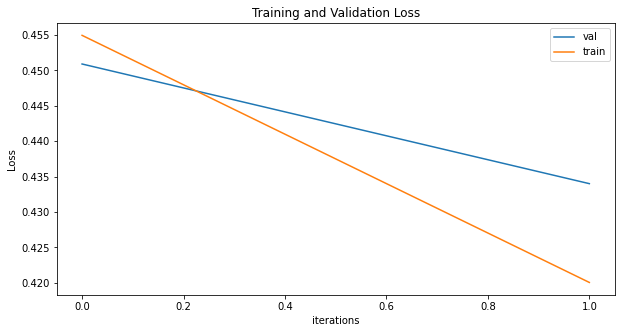

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('/content/drive/MyDrive/upside_down/resnet18/images/train_and_val_loss_resnet18.jpg')
plt.show()

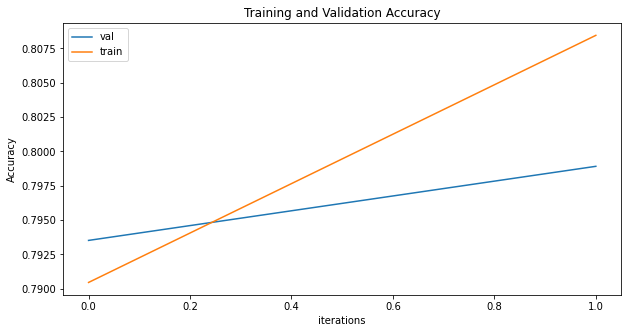

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('/content/drive/MyDrive/upside_down/resnet18/images/train_and_val_acc_resnet18.jpg')
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/name_classifier/models/my_model_epoch_1.pth"
# /content/drive/MyDrive/name_classifier/models

In [ ]:
checkpoint = torch.load(model_path, map_location=params['device'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
from sklearn.metrics import f1_score, precision_score

In [ ]:
def calculate_metrics(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item(), f1_score(target, output), precision_score(target, output)

In [ ]:
def test(test_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            accuracy, f1_score_var, precision = calculate_metrics(output, target)
            # print(accuracy, f1_score_var, precision)
            # break
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1-Score", f1_score_var)
            metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return accuracy, f1_score

In [ ]:
test_accuracy, _ = test(inference_dataloader, model, criterion, epoch, params)

Epoch: 1. Test. Loss: 0.478 | Accuracy: 0.772 | F1-Score: 0.424 | Precision-: 0.508: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]
